In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1013. Microbiome Peanut Allergy/P1013.3. Analyses/P1013.4. Outcome Prediction/Output')
cur_date = "011026"

library(readxl)
library(tidyverse)
library(Hmisc)
library(ggsci)
library(ggrepel)
library(umap)
library(gtsummary)
library(ggpubr)
library(cowplot)

# reading in files
saliva_df = data.frame(read_excel("Input/Processed_Saliva_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE))
stool_df = data.frame(read_excel("Input/Processed_Stool_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE))
saliva_paired_outcome_df = data.frame(read_excel("Input/Saliva_Adj_Paired_Outcome_011026.xlsx")) %>%
    filter(P.Adj < 0.1)
stool_paired_outcome_df = data.frame(read_excel("Input/Stool_Adj_Paired_Outcome_011026.xlsx")) %>%
    filter(P.Adj < 0.1)
saliva_var_imp_df = data.frame(read_excel("Input/RF_Saliva_Covariates_Outcome_Importance_011226.xlsx")) %>%
    filter(MeanDecreaseGini > 0.13)
stool_var_imp_df = data.frame(read_excel("Input/RF_Stool_Covariates_Outcome_Importance_011226.xlsx")) %>%
    filter(MeanDecreaseGini > 0.3)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
combined_saliva_df = saliva_df %>%
    # normalizing
    mutate(across(c(10:ncol(saliva_df)), ~ log(.x + 2))) %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    filter(IgE_Binarized != 'Fail') %>%
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))
combined_stool_df = stool_df %>%
    mutate(across(c(11:ncol(stool_df)), ~ log(.x + 2))) %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    filter(IgE_Binarized != 'Fail') %>%
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome)))

# Comparing Baseline Bacteria Abundances

In [3]:
v1_saliva_df = combined_saliva_df %>%
    # only keep participants' baseline samples and those given active treatment
    filter(Time_Point == 'Pre' & Treatment == 'A') 

v1_stool_df = combined_stool_df %>%
    filter(Time_Point == 'Pre' & Treatment == 'A') 

head(v1_saliva_df)

,Original_Sample_ID,Subject_No,Sample_ID,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FS02baseline,2,Pre_2,Pre,A,Failure,1.873973,14.20,Low,0.6931472,⋯,0.6931472,0.6931472,3.8712010,5.921578,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.736198
2,FS05baseline,4,Pre_4,Pre,A,Failure,3.991781,9.59,Low,3.2580965,⋯,0.6931472,0.6931472,0.6931472,4.718499,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.129899
3,FS07baseline,6,Pre_6,Pre,A,Sustained Unresponsiveness,1.419178,1.32,Low,2.1972246,⋯,0.6931472,0.6931472,0.6931472,7.748029,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.401197
4,FS10baseline,9,Pre_9,Pre,A,Sustained Unresponsiveness,1.389041,0.42,Low,2.3978953,⋯,0.6931472,0.6931472,0.6931472,7.280697,8.360773,0.6931472,0.6931472,0.6931472,0.6931472,2.197225
5,FS12baseline,11,Pre_11,Pre,A,Failure,1.567123,4.34,Low,2.3025851,⋯,0.6931472,0.6931472,0.6931472,2.890372,8.445482,0.6931472,0.6931472,3.6635616,2.1972246,3.496508
6,FS15baseline,14,Pre_14,Pre,A,Failure,3.912329,105.00,High,1.3862944,⋯,2.3025851,0.6931472,0.6931472,3.555348,5.575949,0.6931472,0.6931472,7.2909748,4.0943446,4.060443


In [4]:
# setting seed for reproducibility and running umap
set.seed(12)
saliva_umap_outcome = umap(v1_saliva_df[,c(10:ncol(v1_saliva_df))], random_state = 12)
stool_umap_outcome = umap(v1_stool_df[,c(11:ncol(v1_stool_df))], random_state = 12)

saliva_umap_outcome_df = data.frame(X = saliva_umap_outcome$layout[,1],
                     Y = saliva_umap_outcome$layout[,2],
                     Sample_ID = v1_saliva_df$Sample_ID,
                     Outcome = v1_saliva_df$Outcome,
                     Age = v1_saliva_df$Age,
                     IgE = v1_saliva_df$IgE_Binarized) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) 

stool_umap_outcome_df = data.frame(X = stool_umap_outcome$layout[,1],
                     Y = stool_umap_outcome$layout[,2],
                     Sample_ID = v1_stool_df$Sample_ID,
                     Outcome = v1_stool_df$Outcome,
                     Age = v1_stool_df$Age,
                     IgE = v1_stool_df$IgE_Binarized) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) 

head(saliva_umap_outcome_df)

,X,Y,Sample_ID,Outcome,Age,IgE
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
1,-0.4581162,-0.1800874,Pre_2,Failure,1.873973,Low
2,0.3525093,-1.5438766,Pre_4,Failure,3.991781,Low
3,-0.1031727,0.5201130,Pre_6,Sustained Unresponsiveness,1.419178,Low
4,0.2816024,0.8535709,Pre_9,Sustained Unresponsiveness,1.389041,Low
5,1.0001857,0.4563618,Pre_11,Failure,1.567123,Low
6,-0.1929039,-1.5970746,Pre_14,Failure,3.912329,High


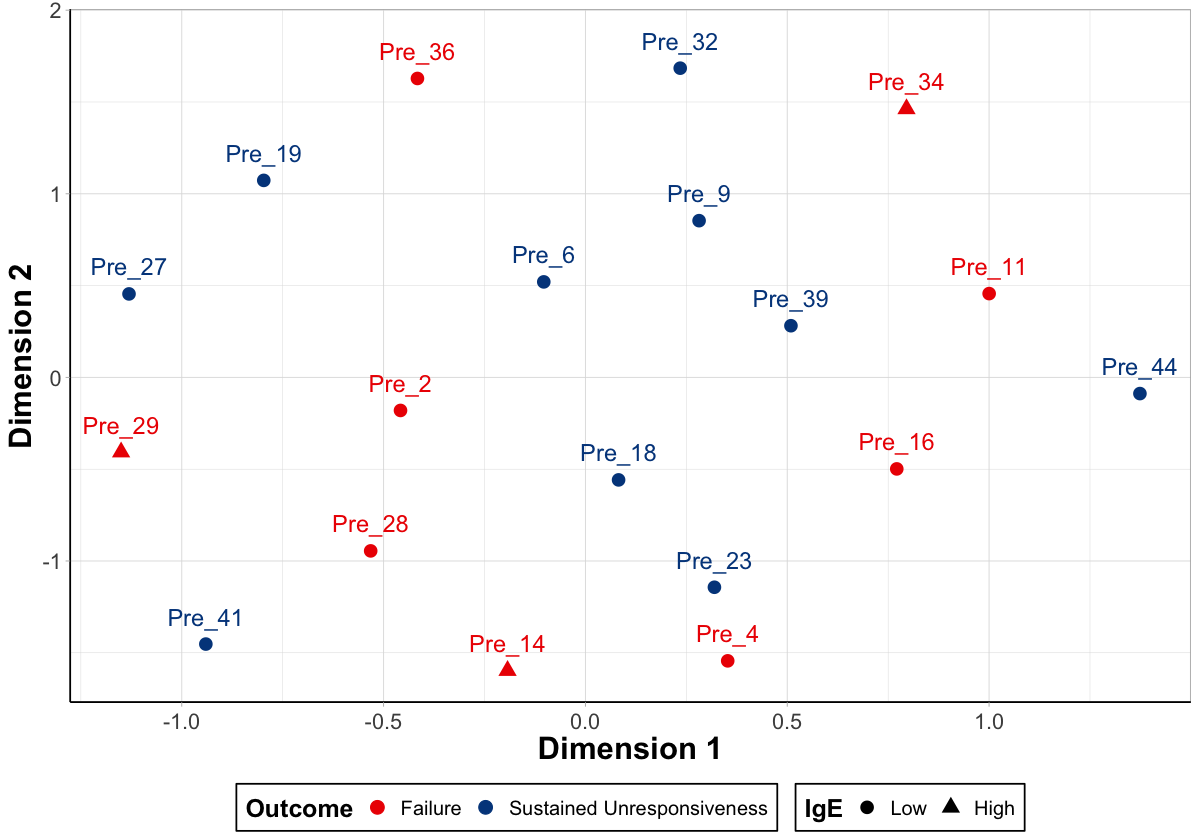

In [5]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
lancet_palette = pal_lancet()(2)

ggplot(saliva_umap_outcome_df, aes(x = X, y = Y, color = Outcome, shape = IgE)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(aes(label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(lancet_palette))

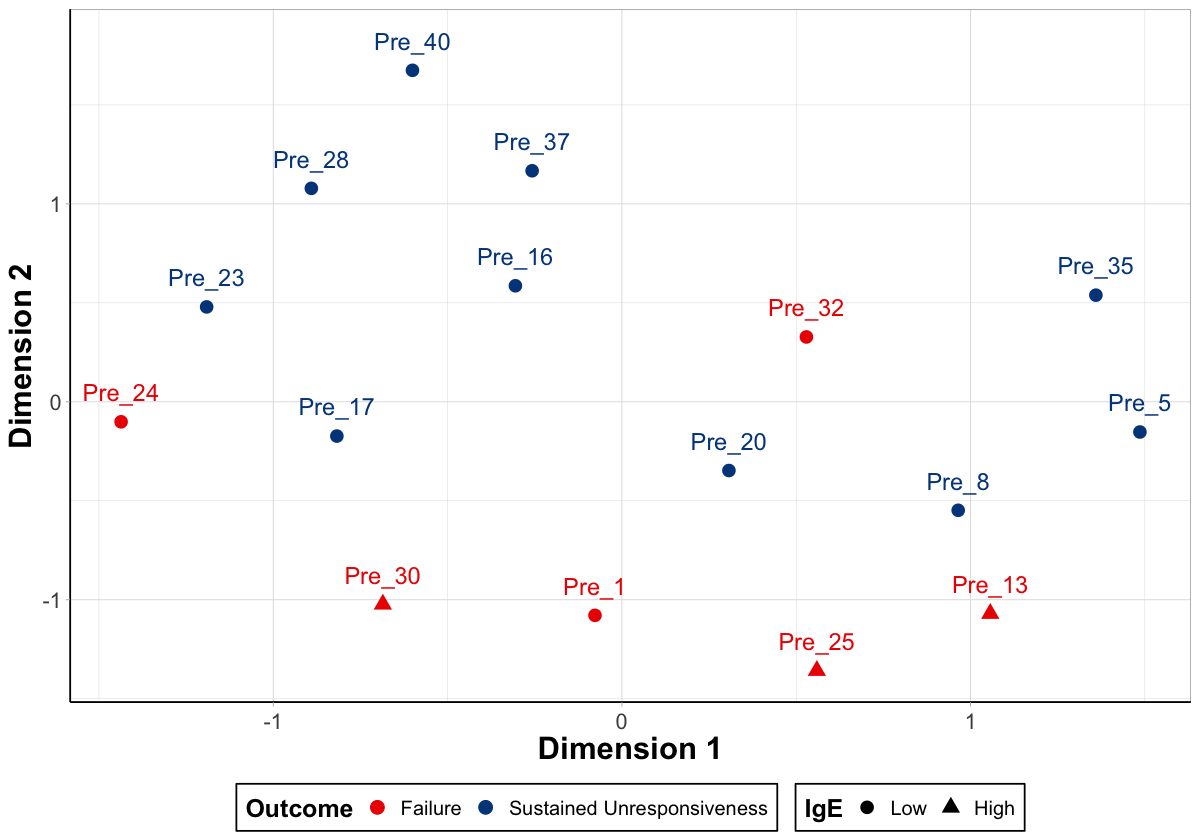

In [6]:
ggplot(stool_umap_outcome_df, aes(x = X, y = Y, color = Outcome, shape = IgE)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(aes(label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(lancet_palette))

In [7]:
v1_saliva_df %>%
    tbl_summary(by = Outcome, missing = "no", 
    include = colnames(v1_saliva_df[6:8]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
    add_n() %>% 
    add_p() %>% # adding p value
    as_tibble()

**Characteristic**,**N**,**Failure** N = 9,**Sustained Unresponsiveness** N = 10,**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Age,19,2.86 (1.04),2.36 (1.05),0.3
IgE,19,55 (71),14 (35),0.002


In [8]:
v1_stool_df %>%
    tbl_summary(by = Outcome, missing = "no", 
    include = colnames(v1_stool_df[7:9]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
    add_n() %>% 
    add_p() %>% # adding p value
    as_tibble()

**Characteristic**,**N**,**Failure** N = 6,**Sustained Unresponsiveness** N = 10,**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Age,16,2.87 (1.06),2.15 (0.92),0.2
IgE,16,80 (78),4 (4),<0.001


In the saliva samples, there were similarities in the saliva microbiome profiles of participants prior to treatment. Additional statistics reveal that participants that went on to have sustained unresponsiveness had significantly lower IgE levels prior to treatment (p value < 0.05).

In the stool samples, there were similarities in the stool microbiome profiles of participants prior to treatment. As with the saliva samples, participants that went on to have sustained unresponsiveness had significantly lower IgE levels prior to treatment (p value < 0.05).

## Comparing IgE levels before treatment

In [9]:
v2_saliva_df = combined_saliva_df %>%
    # only keep participants' baseline samples 
    filter(Time_Point == 'Pre') 

v2_stool_df = combined_stool_df %>%
     filter(Time_Point == 'Pre')

head(v2_saliva_df)

,Original_Sample_ID,Subject_No,Sample_ID,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FS01baseline,1,Pre_1,Pre,P,Failure,3.838356,41.00,High,2.1972246,⋯,4.0775374,2.7080502,0.6931472,5.3706380,6.655440,0.6931472,2.7725887,5.5134287,3.8286414,4.1896547
2,FS02baseline,2,Pre_2,Pre,A,Failure,1.873973,14.20,Low,0.6931472,⋯,0.6931472,0.6931472,3.8712010,5.9215784,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.7361984
3,FS04baseline,3,Pre_3,Pre,P,Failure,3.715068,67.40,High,1.7917595,⋯,0.6931472,0.6931472,0.6931472,0.6931472,3.806662,6.0306853,3.8918203,0.6931472,1.3862944,6.9584484
4,FS05baseline,4,Pre_4,Pre,A,Failure,3.991781,9.59,Low,3.2580965,⋯,0.6931472,0.6931472,0.6931472,4.7184989,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.1298987
5,FS06baseline,5,Pre_5,Pre,P,Failure,2.356164,106.00,High,4.4308168,⋯,0.6931472,0.6931472,3.9512437,6.2441669,7.980708,0.6931472,0.6931472,0.6931472,0.6931472,0.6931472
6,FS07baseline,6,Pre_6,Pre,A,Sustained Unresponsiveness,1.419178,1.32,Low,2.1972246,⋯,0.6931472,0.6931472,0.6931472,7.7480285,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.4011974


In [10]:
# setting seed for reproducibility
set.seed(12)

saliva_umap_ige = umap(v2_saliva_df[,c(10:ncol(v2_saliva_df))], random_state = 12)
stool_umap_ige = umap(v2_stool_df[,c(11:ncol(v2_stool_df))], random_state = 12)

saliva_umap_ige_df = data.frame(X = saliva_umap_ige$layout[,1],
                     Y = saliva_umap_ige$layout[,2],
                     Sample_ID = v2_saliva_df$Sample_ID,
                     IgE = v2_saliva_df$IgE_Binarized,
                     Age = v2_saliva_df$Age) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) 

stool_umap_ige_df = data.frame(X = stool_umap_ige$layout[,1],
                     Y = stool_umap_ige$layout[,2],
                     Sample_ID = v2_stool_df$Sample_ID,
                     IgE = v2_stool_df$IgE_Binarized,
                     Age = v2_stool_df$Age) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) 

head(saliva_umap_ige_df)

,X,Y,Sample_ID,IgE,Age
,<dbl>,<dbl>,<chr>,<fct>,<dbl>
1,1.1463484,-0.4080687,Pre_1,High,3.838356
2,-0.3865497,-0.4928049,Pre_2,Low,1.873973
3,-1.4518215,1.5310854,Pre_3,High,3.715068
4,1.1542358,-0.9102363,Pre_4,Low,3.991781
5,0.3808392,0.6167579,Pre_5,High,2.356164
6,-1.3250287,-0.5672609,Pre_6,Low,1.419178


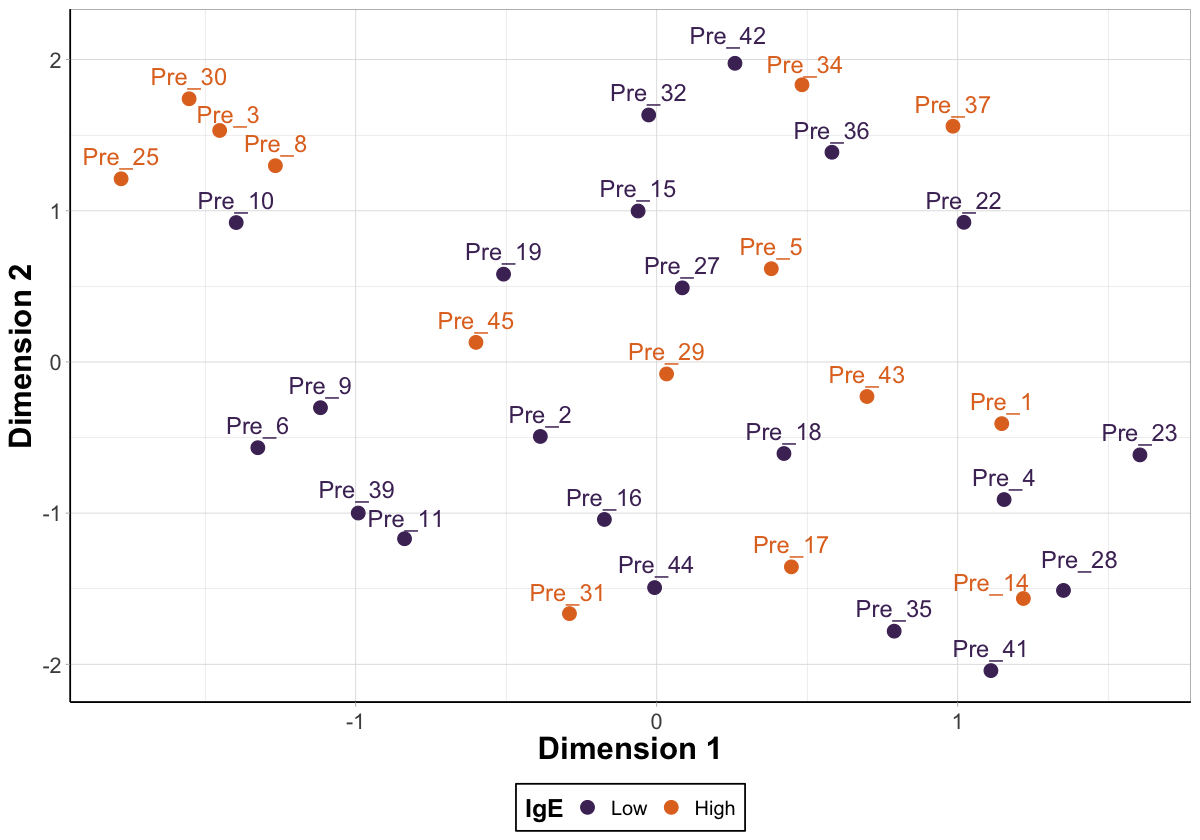

In [11]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
futurama_palette = pal_futurama()(3)

ggplot(saliva_umap_ige_df, aes(x = X, y = Y, color = IgE)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(aes(label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = c("#4c2f65", "#E17327"))

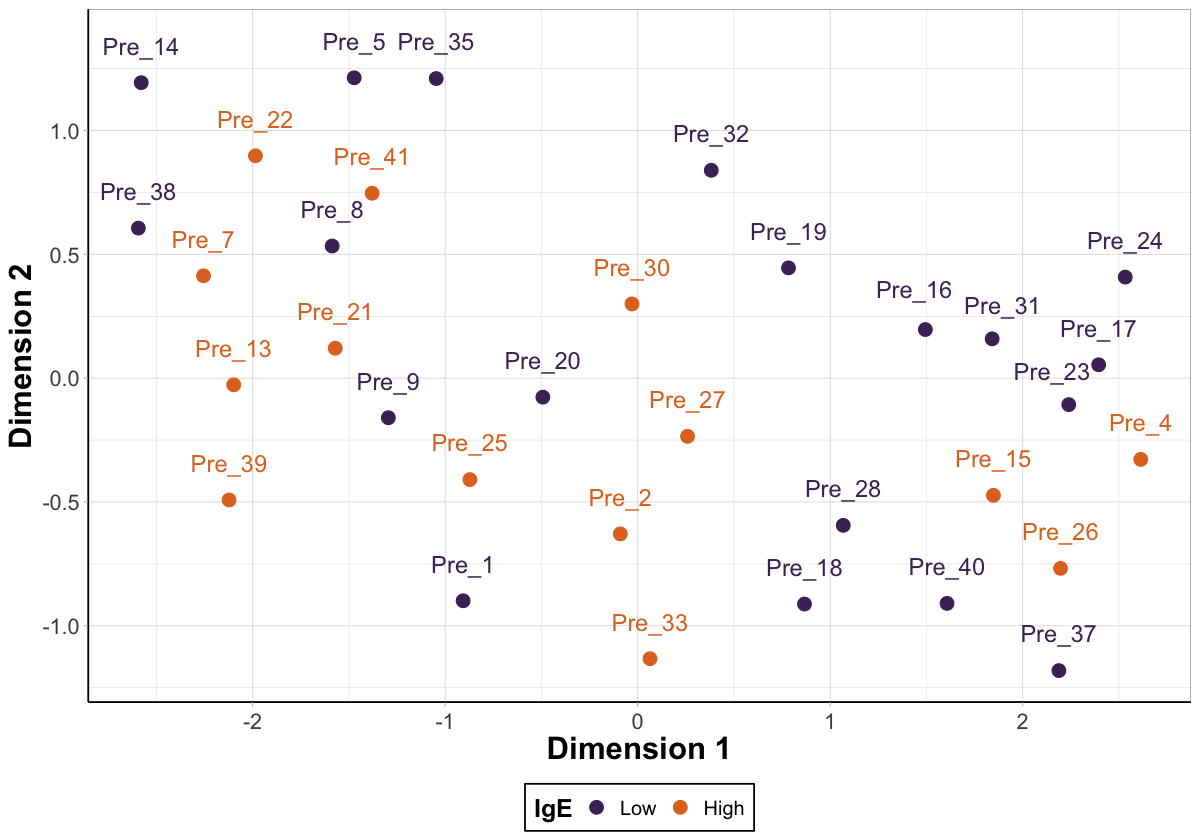

In [12]:
ggplot(stool_umap_ige_df, aes(x = X, y = Y, color = IgE)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(aes(label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = c("#4c2f65", "#E17327"))

In [13]:
v2_saliva_df %>%
    tbl_summary(by = IgE_Binarized, missing = "no", 
    include = colnames(v2_saliva_df[7]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
    add_n() %>% 
    add_p() %>% # adding p value
    as_tibble()

The following warnings were returned during `add_p()`:
! For variable `Age` (`IgE_Binarized`) and "estimate", "statistic", "p.value",
  "conf.low", and "conf.high" statistics: cannot compute exact p-value with
  ties
! For variable `Age` (`IgE_Binarized`) and "estimate", "statistic", "p.value",
  "conf.low", and "conf.high" statistics: cannot compute exact confidence
  intervals with ties


**Characteristic**,**N**,**High** N = 14,**Low** N = 21,**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Age,35,2.75 (0.99),2.47 (0.97),0.4


In [14]:
v2_stool_df %>%
    tbl_summary(by = IgE_Binarized, missing = "no", 
    include = colnames(v2_stool_df[8]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
    add_n() %>% 
    add_p() %>% # adding p value
    as_tibble()

**Characteristic**,**N**,**High** N = 14,**Low** N = 19,**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Age,33,2.58 (1.00),2.26 (0.88),0.4


# Comparing Microbiome Profiles Before and After Treatment

Note: To maximize the sample size, I didn't require participants to have both pre and post samples.

In [15]:
paired_saliva_df = combined_saliva_df %>%
    filter(Treatment == 'A') 

paired_stool_df = combined_stool_df %>%
    filter(Treatment == 'A') 
head(paired_saliva_df)

,Original_Sample_ID,Subject_No,Sample_ID,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FS0236mo,2,Post_2,Post,A,Failure,1.873973,14.20,Low,4.1743873,⋯,6.5510803,0.6931472,3.8066625,4.605170,7.413970,0.6931472,0.6931472,6.0520892,4.9972123,4.828314
2,FS02baseline,2,Pre_2,Pre,A,Failure,1.873973,14.20,Low,0.6931472,⋯,0.6931472,0.6931472,3.8712010,5.921578,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.736198
3,FS0536mo,4,Post_4,Post,A,Failure,3.991781,9.59,Low,2.0794415,⋯,0.6931472,2.9444390,0.6931472,4.948760,7.833204,0.6931472,0.6931472,6.2225763,3.7135721,4.634729
4,FS05baseline,4,Pre_4,Pre,A,Failure,3.991781,9.59,Low,3.2580965,⋯,0.6931472,0.6931472,0.6931472,4.718499,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.129899
5,FS0736mo,6,Post_6,Post,A,Sustained Unresponsiveness,1.419178,1.32,Low,1.3862944,⋯,0.6931472,0.6931472,0.6931472,6.142037,7.407318,2.1972246,0.6931472,5.1298987,4.1431347,6.084499
6,FS07baseline,6,Pre_6,Pre,A,Sustained Unresponsiveness,1.419178,1.32,Low,2.1972246,⋯,0.6931472,0.6931472,0.6931472,7.748029,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.401197


How many participants?

In [16]:
paired_saliva_df %>%
    group_by(Time_Point) %>%
    count()

paired_stool_df %>%
    group_by(Time_Point) %>%
    count()

Time_Point,n
<chr>,<int>
Post,17
Pre,19


Time_Point,n
<chr>,<int>
Post,14
Pre,16


In [17]:
saliva_umap_paired = umap(paired_saliva_df[,c(10:ncol(paired_saliva_df))], random_state = 12)
stool_umap_paired = umap(paired_stool_df[,c(11:ncol(paired_stool_df))], random_state = 12)

saliva_umap_paired_df = data.frame(X = saliva_umap_paired$layout[,1],
                     Y = saliva_umap_paired$layout[,2],
                     Sample_ID = paired_saliva_df$Sample_ID,
                     Time_Point = paired_saliva_df$Time_Point,
                     Outcome = paired_saliva_df$Outcome,
                     Age = paired_saliva_df$Age,
                     IgE = paired_saliva_df$IgE_Binarized) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High')),
          Time_Point = factor(Time_Point, levels = c('Pre', 'Post'))) 

stool_umap_paired_df = data.frame(X = stool_umap_paired$layout[,1],
                     Y = stool_umap_paired$layout[,2],
                     Sample_ID = paired_stool_df$Sample_ID,
                     Time_Point = paired_stool_df$Time_Point,
                     Outcome = paired_stool_df$Outcome,
                     Age = paired_stool_df$Age,
                     IgE = paired_stool_df$IgE_Binarized) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High')),
          Time_Point = factor(Time_Point, levels = c('Pre', 'Post'))) 

head(saliva_umap_paired_df)

,X,Y,Sample_ID,Time_Point,Outcome,Age,IgE
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<dbl>,<fct>
1,0.61058757,1.450683,Post_2,Post,Failure,1.873973,Low
2,-0.09464208,-1.666695,Pre_2,Pre,Failure,1.873973,Low
3,0.14125274,1.960445,Post_4,Post,Failure,3.991781,Low
4,-0.46696901,1.489053,Pre_4,Pre,Failure,3.991781,Low
5,0.19540536,1.365907,Post_6,Post,Sustained Unresponsiveness,1.419178,Low
6,-0.68054384,-2.095174,Pre_6,Pre,Sustained Unresponsiveness,1.419178,Low


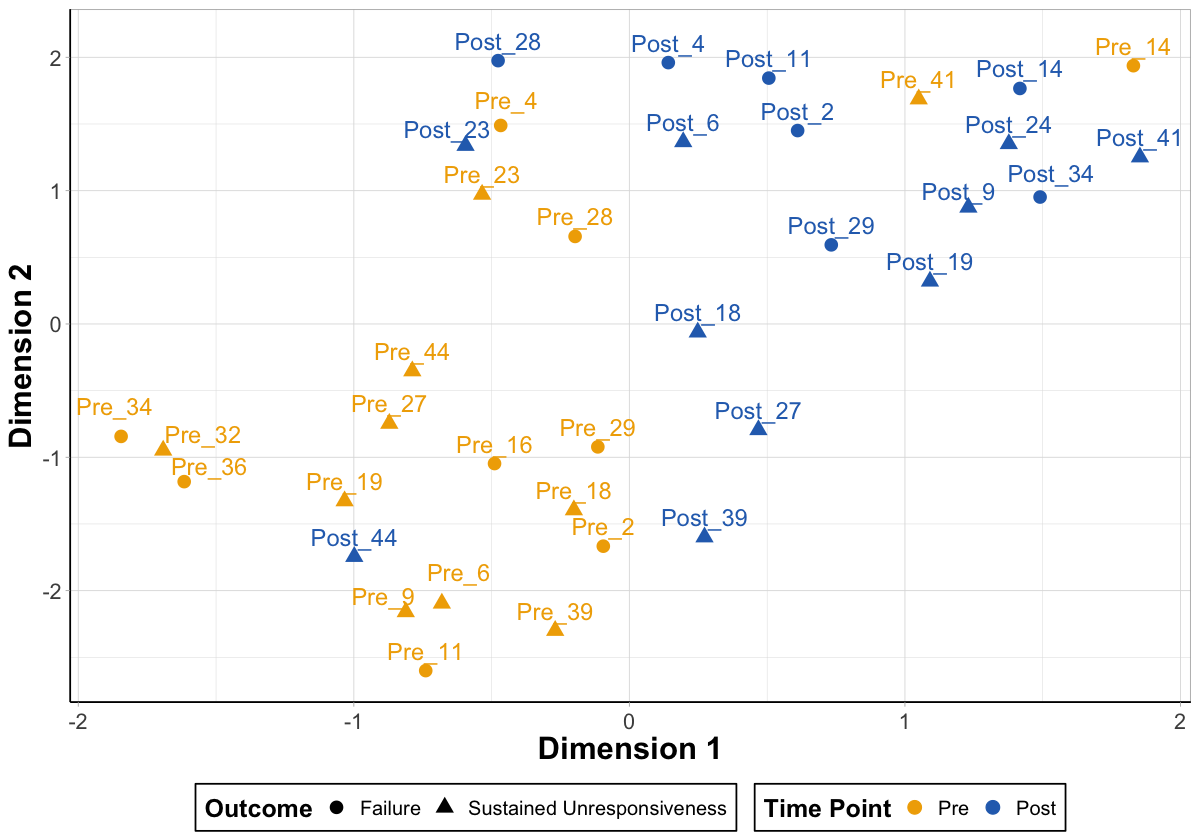

In [18]:
bmj_palette = pal_bmj()(2)

ggplot(saliva_umap_paired_df, aes(x = X, y = Y, color = Time_Point, shape = Outcome)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(data = saliva_umap_paired_df, 
                  aes(x = X, y = Y, label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(name = 'Time Point', values = rev(bmj_palette))

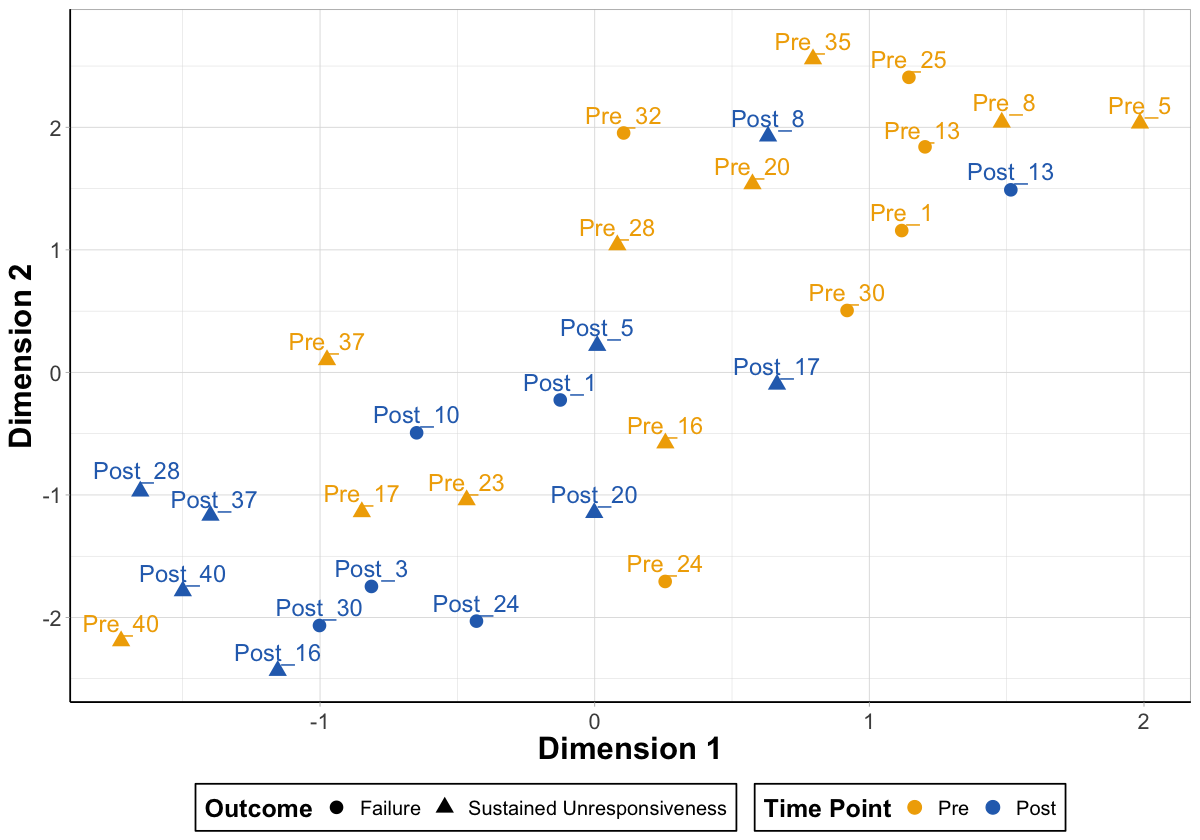

In [19]:
ggplot(stool_umap_paired_df, aes(x = X, y = Y, color = Time_Point, shape = Outcome)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(data = stool_umap_paired_df, 
                  aes(x = X, y = Y,  label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(name = 'Time Point', values = rev(bmj_palette))

## Outcome Differences based on Significant Bacteria
Need to obtain log2 FC between pre and post samples for each subject for significant bacteria only.

In [20]:
`%notin%` <- Negate(`%in%`)
paired_saliva_df2 = combined_saliva_df  %>%
    # removing 11 participants that don't have pre and post samples
    filter(Subject_No %notin% c(1,16,17,20,24,26,31,32,36,37,43),
    # retaining those given treatment
          Treatment == 'A') 

paired_stool_df2 = combined_stool_df  %>%
    # removing 10 participants that don't have pre and post samples
    filter(Subject_No %notin% c(3,10,14,15,23,25,27,32,35,39),
          Treatment == 'A') 

head(paired_saliva_df2)

,Original_Sample_ID,Subject_No,Sample_ID,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FS0236mo,2,Post_2,Post,A,Failure,1.873973,14.20,Low,4.1743873,⋯,6.5510803,0.6931472,3.8066625,4.605170,7.413970,0.6931472,0.6931472,6.0520892,4.9972123,4.828314
2,FS02baseline,2,Pre_2,Pre,A,Failure,1.873973,14.20,Low,0.6931472,⋯,0.6931472,0.6931472,3.8712010,5.921578,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.736198
3,FS0536mo,4,Post_4,Post,A,Failure,3.991781,9.59,Low,2.0794415,⋯,0.6931472,2.9444390,0.6931472,4.948760,7.833204,0.6931472,0.6931472,6.2225763,3.7135721,4.634729
4,FS05baseline,4,Pre_4,Pre,A,Failure,3.991781,9.59,Low,3.2580965,⋯,0.6931472,0.6931472,0.6931472,4.718499,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.129899
5,FS0736mo,6,Post_6,Post,A,Sustained Unresponsiveness,1.419178,1.32,Low,1.3862944,⋯,0.6931472,0.6931472,0.6931472,6.142037,7.407318,2.1972246,0.6931472,5.1298987,4.1431347,6.084499
6,FS07baseline,6,Pre_6,Pre,A,Sustained Unresponsiveness,1.419178,1.32,Low,2.1972246,⋯,0.6931472,0.6931472,0.6931472,7.748029,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.401197


In [21]:
# getting FC
log_saliva_df = lag(paired_saliva_df2[,10:ncol(saliva_df)])/paired_saliva_df2[,10:ncol(saliva_df)]
log_saliva_df = log_saliva_df[seq_len(nrow(log_saliva_df)) %% 2 == 0, ]
log2FC_saliva_df = cbind(paired_saliva_df2[,c(2,6:9)] %>%
                               unique() %>% 
                               remove_rownames, log_saliva_df)

log_stool_df = lag(paired_stool_df2[,11:ncol(stool_df)])/paired_stool_df2[,11:ncol(stool_df)]
log_stool_df = log_stool_df[seq_len(nrow(log_stool_df)) %% 2 == 0, ]
log2FC_stool_df = cbind(paired_stool_df2[,c(3,7:10)] %>%
                               unique() %>% 
                               remove_rownames, log_stool_df)

head(log2FC_saliva_df)

,Subject_No,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_874,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_875,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.__,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.s__graevenitzii,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2,Failure,1.873973,14.20,Low,6.0223678,1.140281,8.647458,1.0888268,1.2622362,⋯,9.451211,1.000000,0.9833286,0.7776930,0.9130512,1.000000,1.0000000,8.7313190,7.209453,1.0194492
4,4,Failure,3.991781,9.59,Low,0.6382382,1.000000,1.623249,0.7974088,1.1740045,⋯,1.000000,4.247928,1.0000000,1.0487996,1.1013559,0.185449,0.3868528,1.0364246,1.028429,0.9034738
6,6,Sustained Unresponsiveness,1.419178,1.32,Low,0.6309298,4.700440,1.000000,1.0305566,1.5563025,⋯,1.000000,1.000000,1.0000000,0.7927226,0.9758216,3.169925,0.2398125,7.4008794,2.129150,1.7889286
8,9,Sustained Unresponsiveness,1.389041,0.42,Low,1.1005724,1.000000,1.000000,1.4281986,8.0056245,⋯,1.000000,1.000000,1.0000000,0.5133670,0.9129980,2.584963,1.0000000,8.9158794,4.643856,2.7702106
10,11,Failure,1.567123,4.34,Low,1.4771213,3.807355,1.000000,1.5424305,2.0714662,⋯,1.000000,1.000000,1.0000000,2.2108715,1.0270003,1.000000,1.0000000,1.7658363,1.952672,1.5892510
12,14,Failure,3.912329,105.00,High,1.9534453,1.000000,1.000000,0.9052225,0.8867124,⋯,1.755875,1.000000,1.0000000,1.8356838,1.4479534,1.000000,1.0000000,0.8403361,1.244094,0.1707073


In [22]:
v3_saliva_df = log2FC_saliva_df %>%
    pivot_longer(cols = 6:ncol(log2FC_saliva_df), names_to = 'Name', values_to = 'log2FC') %>%
    #filter(Name %in% saliva_paired_outcome_df$Name) %>%
    filter(Name %in% saliva_var_imp_df$Predictor) %>%
    pivot_wider(names_from = Name, values_from = log2FC)

v3_stool_df = log2FC_stool_df %>%
    pivot_longer(cols = 6:ncol(log2FC_stool_df), names_to = 'Name', values_to = 'log2FC') %>%
    #filter(Name %in% stool_paired_outcome_df$Name) %>%
    filter(Name %in% stool_var_imp_df$Predictor) %>%
    pivot_wider(names_from = Name, values_from = log2FC)


head(v3_saliva_df)

Subject_No,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.s__graevenitzii,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Schaalia.s__lingnae,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Porphyromonadaceae.g__Porphyromonas.__,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Porphyromonadaceae.g__Porphyromonas.s__pasteri,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Prevotellaceae.g__Alloprevotella.s__sp._HMT_308,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Prevotellaceae.g__Prevotella.s__pallens,k__Bacteria.p__Bacteroidetes.c__Flavobacteriia.o__Flavobacteriales.f__Weeksellaceae.g__Weeksellaceae_.G.1..s__sp._HMT_931,k__Bacteria.p__Cyanobacteria.c__Oscillatoriophycideae.o__Oscillatoriales.f__Microcoleaceae.g__Arthrospira.s__platensis,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus.__,k__Bacteria.p__Firmicutes.c__Clostridia.o__Eubacteriales.f__Lachnospiraceae.g__Lachnoanaerobaculum.s__umeaense,k__Bacteria.p__Firmicutes.c__Clostridia.o__Eubacteriales.f__Lachnospiraceae.g__Stomatobaculum.s__sp._HMT_097,k__Bacteria.p__Firmicutes.c__Negativicutes.o__Veillonellales.f__Veillonellaceae.g__Veillonella.s__sp._HMT_780,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacterales.__.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,Failure,1.873973,14.20,Low,6.0223678,1.2622362,1.3470711,1.0000000,0.9266187,1.298568,2.088888,0.2398125,6.8454901,0.9191040,1.1753019,2.0028068,0.7021969,0.9697587,0.7776930
4,Failure,3.991781,9.59,Low,0.6382382,1.1740045,0.1714416,1.6968370,0.9882322,6.599913,1.764083,4.5849625,1.0000000,0.9600796,0.7638138,0.5073562,7.6934870,0.9585569,1.0487996
6,Sustained Unresponsiveness,1.419178,1.32,Low,0.6309298,1.5563025,4.5235620,0.7429794,1.1060620,1.000000,6.491853,0.5363958,3.0000000,0.9664130,1.1059031,4.3923174,0.7213037,1.1376056,0.7927226
9,Sustained Unresponsiveness,1.389041,0.42,Low,1.1005724,8.0056245,6.0443941,0.1056917,8.9336907,7.434628,7.149747,0.1965616,0.2890648,0.9135577,4.0000000,7.8073549,0.4587886,1.0000000,0.5133670
11,Failure,1.567123,4.34,Low,1.4771213,2.0714662,1.0162105,0.8000274,1.0304626,8.154818,2.682732,5.6724253,0.3010300,0.9802219,1.0919787,1.0935418,7.3575520,1.0256458,2.2108715
14,Failure,3.912329,105.00,High,1.9534453,0.8867124,0.1433223,1.0000000,1.2014480,1.161721,1.244176,3.0000000,1.0000000,0.9076735,1.3001699,1.1581349,0.6263045,0.5867778,1.8356838


In [23]:
saliva_umap_sig_outcome = umap(v3_saliva_df[,c(6:ncol(v3_saliva_df))], n_neighbors = 10, random_state = 12)
stool_umap_sig_outcome = umap(v3_stool_df[,c(6:ncol(v3_stool_df))], n_neighbors = 10, random_state = 12)

saliva_umap_sig_outcome_df = data.frame(X = saliva_umap_sig_outcome$layout[,1],
                     Y = saliva_umap_sig_outcome$layout[,2],
                     Subject_No = v3_saliva_df$Subject_No,
                     Outcome = v3_saliva_df$Outcome,
                     Age = v3_saliva_df$Age) 

stool_umap_sig_outcome_df = data.frame(X = stool_umap_sig_outcome$layout[,1],
                     Y = stool_umap_sig_outcome$layout[,2],
                     Subject_No = v3_stool_df$Subject_No,
                     Outcome = v3_stool_df$Outcome,
                     Age = v3_stool_df$Age) 

head(saliva_umap_sig_outcome_df)

,X,Y,Subject_No,Outcome,Age
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.67069885,-0.7406564,2,Failure,1.873973
2,0.31870747,-1.4832721,4,Failure,3.991781
3,0.39085845,-0.2723516,6,Sustained Unresponsiveness,1.419178
4,1.51217152,0.6274572,9,Sustained Unresponsiveness,1.389041
5,-0.06518253,-1.9083186,11,Failure,1.567123
6,-0.51279962,0.3101125,14,Failure,3.912329


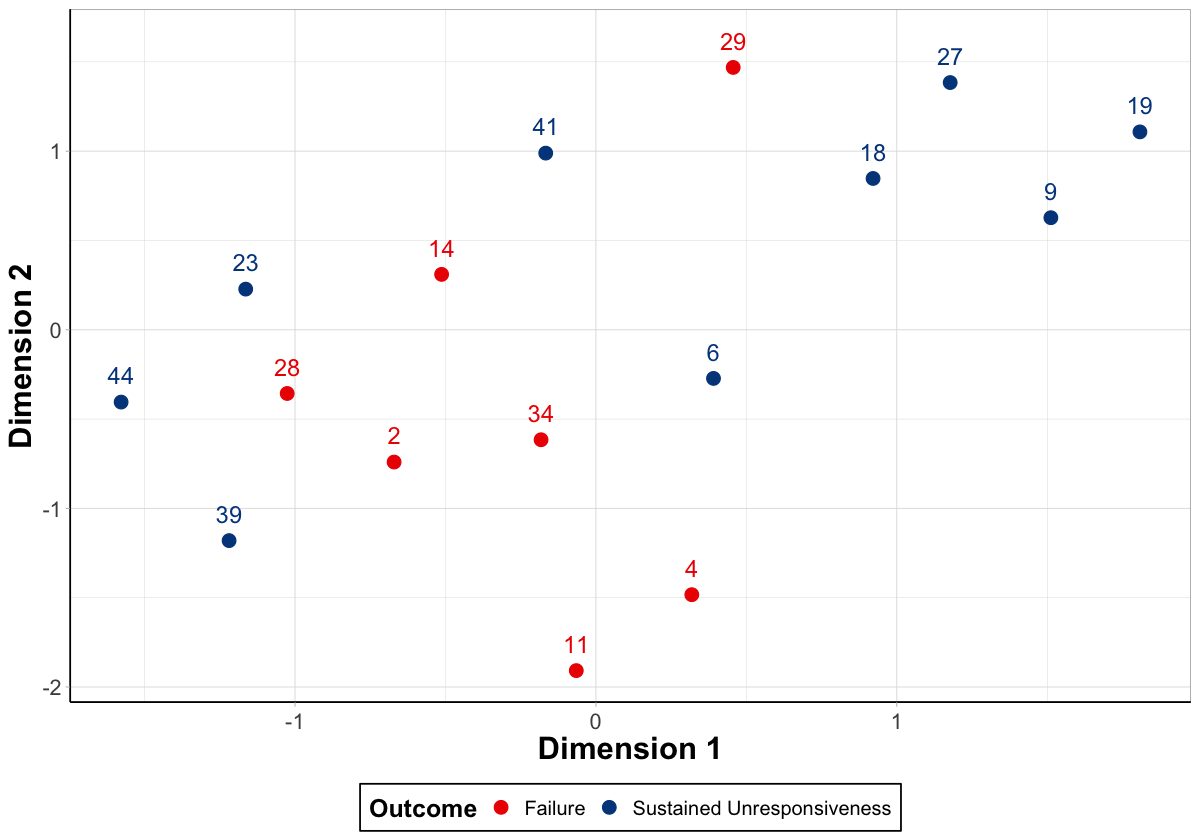

In [24]:
ggplot(saliva_umap_sig_outcome_df, aes(x = X, y = Y, color = Outcome)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(aes(label = Subject_No), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(lancet_palette))

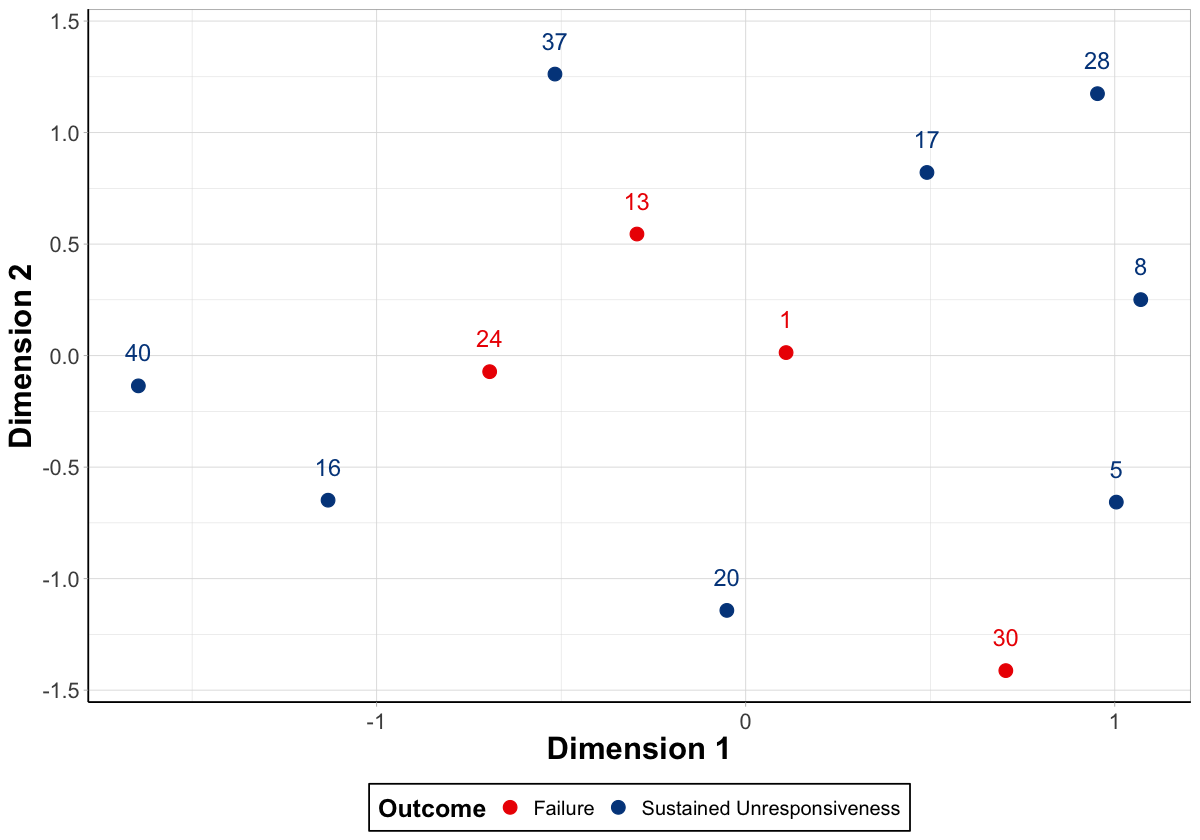

In [25]:
ggplot(stool_umap_sig_outcome_df, aes(x = X, y = Y, color = Outcome)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(aes(label = Subject_No), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(lancet_palette))

Running additional statistics to quantify trends I'm seeing.

In [26]:
v3_saliva_df %>%
    tbl_summary(by = Outcome, missing = "no", 
    include = colnames(v3_saliva_df[2:4]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
    add_n() %>% 
    add_p() %>% # adding p value from wilcox
    as_tibble()

**Characteristic**,**N**,**Failure** N = 7,**Sustained Unresponsiveness** N = 9,**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Age,16,3.07 (0.98),2.44 (1.08),0.2
IgE,16,69 (76),2 (2),<0.001


In [27]:
v3_stool_df %>%
    tbl_summary(by = Outcome, missing = "no", 
    include = colnames(v3_stool_df[2:4]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
    add_n() %>% 
    add_p() %>% 
    as_tibble()

**Characteristic**,**N**,**Failure** N = 4,**Sustained Unresponsiveness** N = 8,**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Age,12,3.10 (0.91),2.10 (0.81),0.073
IgE,12,72 (70),4 (5),0.008


What we're capturing here is a shift in the microbiome, specifically in stool samples, which may suggest that treatment may shift the stool microbiome enough to be associated with sustained unresponsiveness.

In the saliva samples, there is no clear clustering between subjects' outcome based on their log2 fold changes before and after treatment. Additional statistics reveal that there were significant differences in IgE concentrations with participants that went on to have sustained unresponsiveness having lower IgE levels prior to treatment (p value < 0.05).

In the stool samples, there do seem to be differences in global microbiome changes after treatment between subjects' outcome. However, additonal statistics reveal that there were significant differences in IgE concentrations with participants that went on to have sustained unresponsiveness having lower IgE levels prior to treatment (p value < 0.05). The differences in ages of the participants was almost significant (p value < 0.1).

Further research is needed to tease out the association and intersection between the significantly different bacteria, age, and IgE concentrations. REVISE!!

## Determining if there is an association with the microbiome post treatment and outcome

In [28]:
v4_saliva_df = combined_saliva_df %>%
    # only keep participants' post samples and those given active treatment
    filter(Time_Point == 'Post' & Treatment == 'A') %>%
    pivot_longer(cols = 10:ncol(combined_saliva_df), names_to = 'Name', values_to = 'Value') %>%
    #filter(Name %in% saliva_paired_outcome_df$Name) %>%
    filter(Name %in% saliva_var_imp_df$Predictor) %>%
    pivot_wider(names_from = Name, values_from = Value)

v4_stool_df = combined_stool_df %>%
    filter(Time_Point == 'Post' & Treatment == 'A') %>%
    pivot_longer(cols = 11:ncol(combined_stool_df), names_to = 'Name', values_to = 'Value') %>%
    #filter(Name %in% stool_paired_outcome_df$Name) %>%
    filter(Name %in% stool_var_imp_df$Predictor) %>%
    pivot_wider(names_from = Name, values_from = Value)

head(v4_saliva_df)

Original_Sample_ID,Subject_No,Sample_ID,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,⋯,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Prevotellaceae.g__Alloprevotella.s__sp._HMT_308,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Prevotellaceae.g__Prevotella.s__pallens,k__Bacteria.p__Bacteroidetes.c__Flavobacteriia.o__Flavobacteriales.f__Weeksellaceae.g__Weeksellaceae_.G.1..s__sp._HMT_931,k__Bacteria.p__Cyanobacteria.c__Oscillatoriophycideae.o__Oscillatoriales.f__Microcoleaceae.g__Arthrospira.s__platensis,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus.__,k__Bacteria.p__Firmicutes.c__Clostridia.o__Eubacteriales.f__Lachnospiraceae.g__Lachnoanaerobaculum.s__umeaense,k__Bacteria.p__Firmicutes.c__Clostridia.o__Eubacteriales.f__Lachnospiraceae.g__Stomatobaculum.s__sp._HMT_097,k__Bacteria.p__Firmicutes.c__Negativicutes.o__Veillonellales.f__Veillonellaceae.g__Veillonella.s__sp._HMT_780,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacterales.__.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FS0236mo,2,Post_2,Post,A,Failure,1.873973,14.20,Low,4.174387,⋯,5.6903595,6.150603,0.6931472,4.7449321,8.700514,4.499810,5.552960,3.784190,4.077537,4.605170
FS0536mo,4,Post_4,Post,A,Failure,3.991781,9.59,Low,2.079442,⋯,4.5747110,5.814131,3.1780538,0.6931472,9.003193,4.330733,2.197225,5.332719,4.442651,4.948760
FS0736mo,6,Post_6,Post,A,Sustained Unresponsiveness,1.419178,1.32,Low,1.386294,⋯,0.6931472,4.499810,2.6390573,2.0794415,9.288319,4.234107,3.044522,5.043425,5.537334,6.142037
FS1036mo,9,Post_9,Post,A,Sustained Unresponsiveness,1.389041,0.42,Low,2.639057,⋯,5.1532916,4.955827,0.6931472,0.6931472,8.543446,2.772589,5.411646,3.610918,3.663562,3.737670
FS1236mo,11,Post_11,Post,A,Failure,1.567123,4.34,Low,3.401197,⋯,5.6524892,5.220356,3.9318256,0.6931472,9.266626,5.209486,4.477337,5.099866,4.753590,6.390241
FS1536mo,14,Post_14,Post,A,Failure,3.912329,105.00,High,2.708050,⋯,6.7334019,7.711997,2.0794415,0.6931472,8.580356,5.365976,5.877736,2.397895,2.708050,6.526495


In [29]:
# setting seed for reproducibility and running umap
set.seed(12)
saliva_umap_post = umap(v4_saliva_df[,c(10:ncol(v4_saliva_df))], n_neighbors = 10, random_state = 12)
stool_umap_post = umap(v4_stool_df[,c(11:ncol(v4_stool_df))], n_neighbors = 10, random_state = 12)

saliva_umap_post_df = data.frame(X = saliva_umap_post$layout[,1],
                     Y = saliva_umap_post$layout[,2],
                     Sample_ID = v4_saliva_df$Sample_ID,
                     Outcome = v4_saliva_df$Outcome,
                     Age = v4_saliva_df$Age,
                     IgE = v4_saliva_df$IgE_Binarized) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) 

stool_umap_post_df = data.frame(X = stool_umap_post$layout[,1],
                     Y = stool_umap_post$layout[,2],
                     Sample_ID = v4_stool_df$Sample_ID,
                     Outcome = v4_stool_df$Outcome,
                     Age = v4_stool_df$Age,
                     IgE = v4_stool_df$IgE_Binarized) %>%
    mutate(IgE = factor(IgE, levels = c('Low', 'High'))) 

head(saliva_umap_post_df)

,X,Y,Sample_ID,Outcome,Age,IgE
,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<fct>
1,-1.1897908,-0.7167900521,Post_2,Failure,1.873973,Low
2,-0.5605109,0.8994516329,Post_4,Failure,3.991781,Low
3,0.1380364,0.5596684617,Post_6,Sustained Unresponsiveness,1.419178,Low
4,-0.7128229,-0.5446248957,Post_9,Sustained Unresponsiveness,1.389041,Low
5,-0.9584447,0.4318752593,Post_11,Failure,1.567123,Low
6,-1.4750776,-0.0002858906,Post_14,Failure,3.912329,High


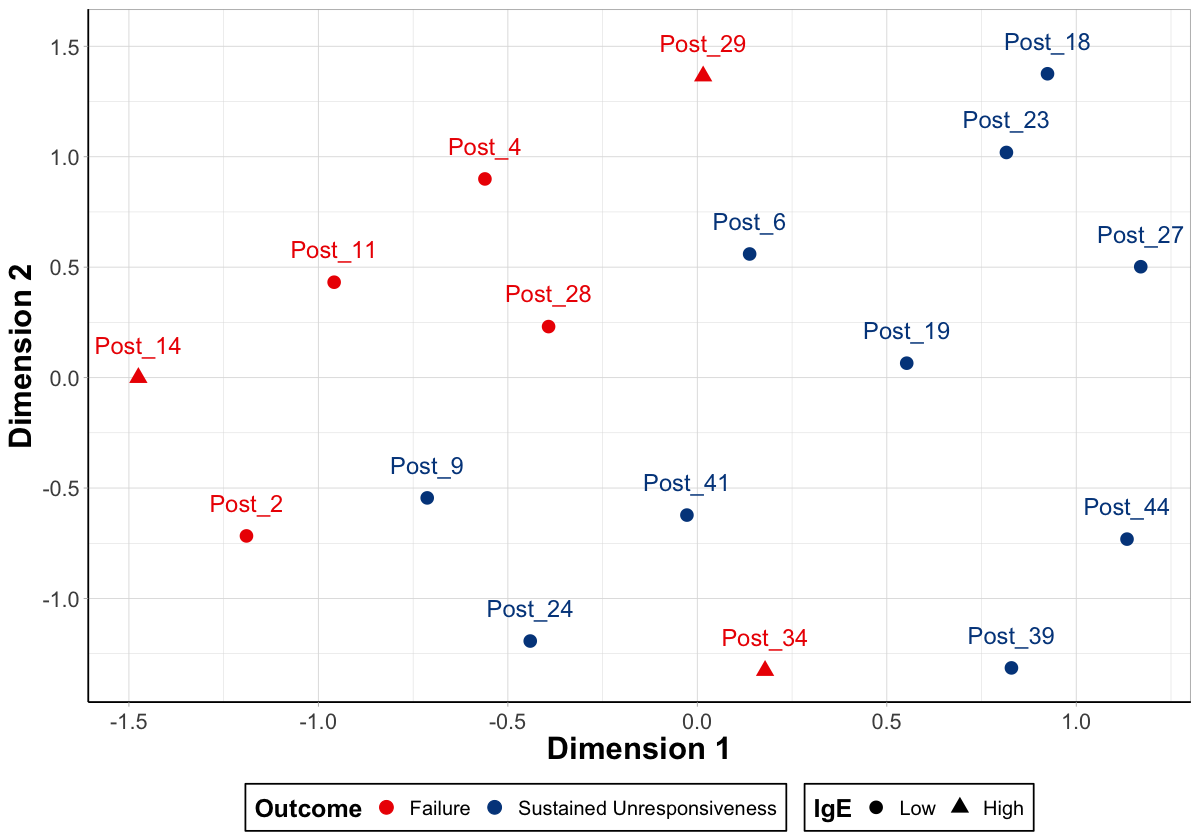

In [30]:
ggplot(saliva_umap_post_df, aes(x = X, y = Y, color = Outcome, shape = IgE)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(aes(label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(lancet_palette))

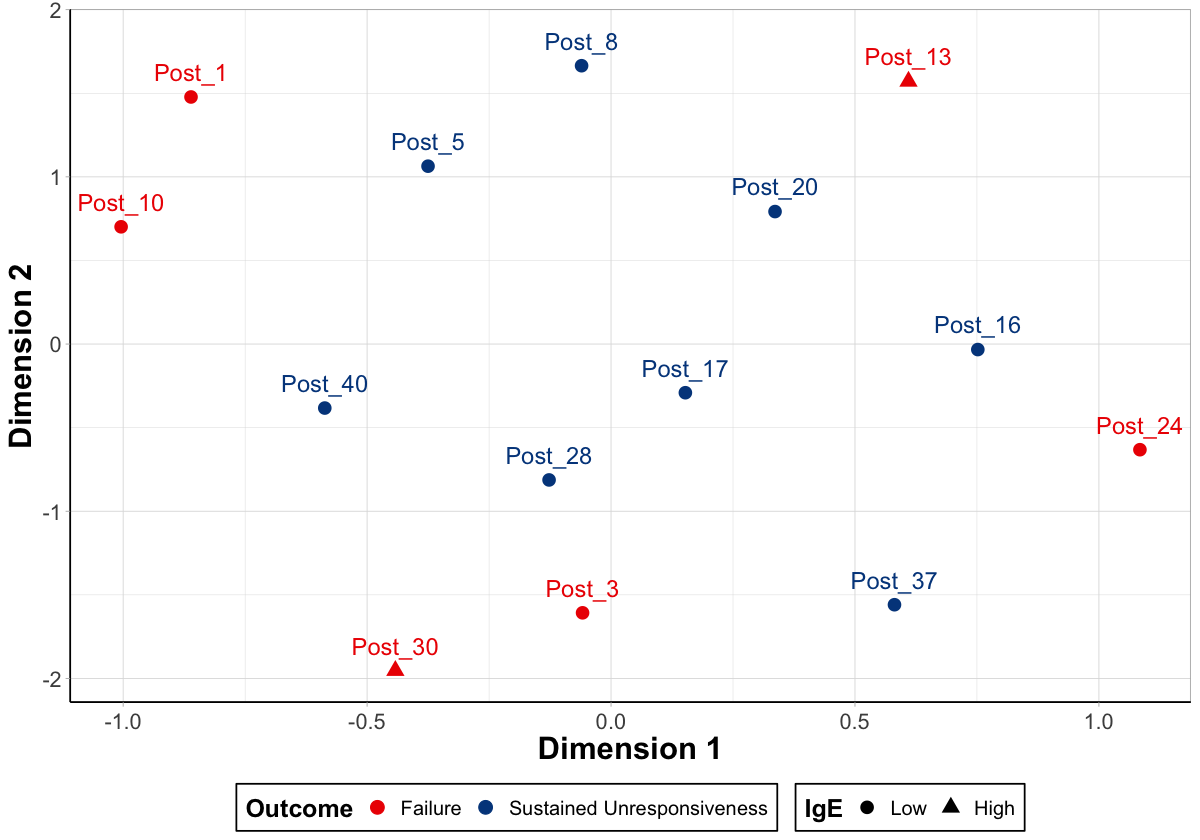

In [31]:
ggplot(stool_umap_post_df, aes(x = X, y = Y, color = Outcome, shape = IgE)) + 
  geom_point(size = 3.5) + 
  geom_text_repel(aes(label = Sample_ID), 
                  segment.size = 0, size = 5, show.legend = FALSE, nudge_y = 0.15) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1', y = 'Dimension 2') + #changing axis labels 

  scale_color_manual(values = rev(lancet_palette))

In [32]:
v4_saliva_df %>%
    tbl_summary(by = Outcome, missing = "no", 
    include = colnames(v4_saliva_df[6:8]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
    add_n() %>% 
    add_p() %>% # adding p value
    as_tibble()

**Characteristic**,**N**,**Failure** N = 7,**Sustained Unresponsiveness** N = 10,**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Age,17,3.07 (0.98),2.35 (1.06),0.11
IgE,17,69 (76),2 (2),<0.001


In [33]:
v4_stool_df %>%
    tbl_summary(by = Outcome, missing = "no", 
    include = colnames(v4_stool_df[7:9]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
    add_n() %>% 
    add_p() %>% # adding p value
    as_tibble()

**Characteristic**,**N**,**Failure** N = 6,**Sustained Unresponsiveness** N = 8,**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Age,14,2.99 (1.05),2.10 (0.81),0.081
IgE,14,50 (64),4 (5),0.008
